**Πριν ξεκινήσεις να τρέχεις τον κώδικα**

Κάνε κλικ στο <kbd>Runtime</kbd> στην κορυφή της σελίδας, και στις επιλογές <kbd>change runtime type</kbd> ή <kbd>runtime options</kbd>. Εκεί επίλεξε ένα κουτάκι που λέει <kbd>(T4) GPU</kbd>.

**Πώς χρησιμοποιείς αυτό το αρχείο;**

Αυτό το αρχείο είναι ένα *jupyter notebook*, που αποτελείται από κελιά κειμένου (όπως αυτό) και κελιά κώδικα (όπως το παραπάνω). Μπορείς να τρέξεις τα κελιά κώδικα με <kbd>shift</kbd> + <kbd>enter</kbd>. Πριν προχωρήσεις, είναι σημαντικό να τρέξεις το παραπάνω κελί, ώστε o υπολογιστής να μπορεί να εισάγει όλες τις απαραίτητες συναρτήσεις.


In [99]:
import pip

import numpy as np
import os
from glob import glob
import torch
from PIL import Image
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F

%pip install medmnist

%pip install SimpleITK
import SimpleITK as sitk


!git clone https://github.com/NicosStarreveld/WorkshopCNNs.git

fatal: destination path 'WorkshopCNNs' already exists and is not an empty directory.


# Τα μαθηματικά πίσω από την ΤΝ - Εφαρμογή: ιατρικά δεδομένα

Τα νευρωνικά δίκτυα (CNNs) μπορούν να χρησιμοποιηθούν για την αυτόματη ερμηνεία εικόνων. Οι υπολογιστές είναι μάλιστα καλύτεροι σε ορισμένες εργασίες ανάλυσης εικόνας από τους ανθρώπους, επειδή οι άνθρωποι έχουν μικρή διάρκεια συγκέντρωσης. Σ' αυτό το εργαστήριο θα ρίξουμε μια ματιά στο πώς ένας υπολογιστής μπορεί να ερμηνεύει εικόνες. Θα εργαστούμε με ένα (δημόσιο) ιατρικό σύνολο δεδομένων και θα εκπαιδεύσουμε το δικό μας δίκτυο που μπορεί να ξεχωρίζει μεταξύ εικόνων δοντιών με και χωρίς απονεύρωση.

### Ψηφιακές εικόνες

Ο υπολογιστής βλέπει μια εικόνα ως έναν μεγάλη πίνακα με αριθμούς, κάθε στοιχείο του πίνακα (γνωστότερο ως *pixel*) περιέχει την τοπική ένταση της εικόνας. Στην περίπτωση μιας έγχρωμης εικόνας, πρόκειται για τρεις πίνακες τον έναν πάνω στον άλλο, που αντιπροσωπεύουν αντίστοιχα το κόκκινο, το μπλε και το πράσινο κανάλι. Στην περίπτωση μιας ασπρόμαυρης εικόνας, η ψηφιακή εικόνα είναι ένας μοναδικός πίνακας με εντάσεις.

In [100]:
#definieert twee functies die je later kan gebruiken om de images te openen en te visualiseren
def open_img(path):
    if path.endswith('.png'):
        return np.array(Image.open(path).convert('L'))
    elif path.endswith('.mhd'):
        return sitk.GetArrayFromImage(sitk.ReadImage(path))[32,:,:] # return 1 slice of the image

def visualize(img, clim=[-300,450]):
    plt.imshow(img, cmap='gray', clim=clim)
    plt.axis('off')
    plt.show()

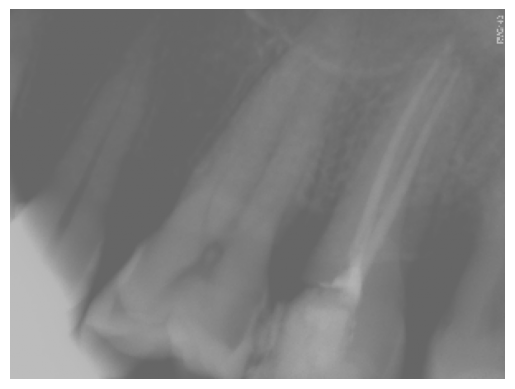

In [101]:
# inladen van beeld van de ribbenkast
# definieer pad naar beeld
# img_path = 'data/ribs/VinDr_RibCXR_train_000.png'
img_path = 'WorkshopCNNs/Xrays_with/167.png'
img = open_img(img_path)
# visualiseer beeld
visualize(img)

In [ ]:
print(np.shape(img))

# Hoe veel pixels zijn dit?

(224, 300)


### Convolutions

Ένας υπολογιστής μπορεί να κατανοήσει μια εικόνα μέσω των λεγόμενων convolutions (συνέληξεις). Ένα convolution αποτελείται πάντα από έναν *πυρήνα* (kernel), έναν μικρό πίνακα που περιέχει ένα χαρακτηριστικό μοτίβο, το οποίο πολλαπλασιάζεται τοπικά με τις εντάσεις της εικόνας. Στην παρακάτω κινούμενη εικόνα, το ανώτερο πράσινο επίπεδο είναι ο πυρήνας, και το μπλε επίπεδο είναι η εικόνα που πρέπει να ερμηνευτεί, η μετακίνηση του πυρήνα ονομάζεται convolution. Το αποτέλεσμα ενός convolution είναι ακόμα ένας *πίνακας*, ο οποίος έχει παρόμοιες διαστάσεις με την αρχική εικόνα.

![](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif?20190413174630)

 Με μια συνελικτική λειτουργία στην ουσία συγκρίνεται η ένταση κάθε pixel με αυτή των γειτόνων του, ανάλογα με το μοτίβο στον πυρήνα. Επιλέγοντας έξυπνα το μοτίβο στον πυρήνα, μπορούν να αναγνωριστούν ορισμένα χαρακτηριστικά στην εικόνα, για παράδειγμα οι κάθετες άκρες. Αποτελεσματικά, για κάθε pixel εξετάζεται πώς το περιβάλλον του ταιριάζει με το μοτίβο στον πυρήνα. Επιπλέον, μια συνελικτική λειτουργία μπορεί να χρησιμοποιηθεί για τη μείωση του θορύβου σε μια εικόνα, κάτι που ονομάζεται *smoothing*.

Παρακάτω παρουσιάζουμε μερικά παραδείγματα συνελικτικών πυρήνων, και είναι δική σας δουλειά να περιγράψετε τι αποτέλεσμα έχουν στην εικόνα.

In [102]:

def apply_conv(image, kernel, iter=1):
    image, kernel = torch.from_numpy(image).float(), torch.from_numpy(kernel).float()
    img_shape, kernel_shape = image.shape, kernel.shape
    fig, ax = plt.subplots(1,1)
    for level in range(iter):
        image = F.conv2d(image.reshape(1,1, img_shape[0], img_shape[1]),
                         kernel.reshape(1,1, kernel_shape[0], kernel_shape[1]),
                         padding='same').squeeze()
        ax.imshow(image.numpy(), cmap='gray', clim=[-300,450])
        ax.set_title(f'Applied convolution {level+1} times')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)
        plt.close()

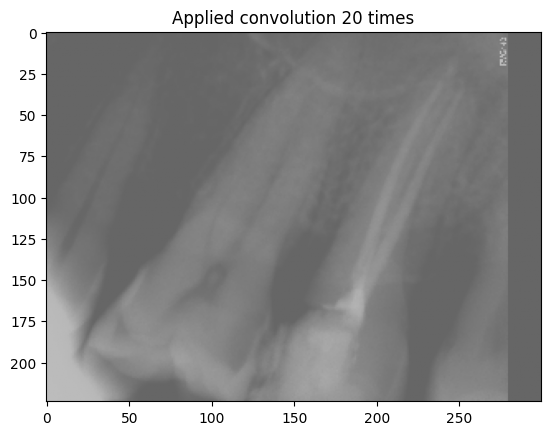

In [ ]:
# convolutiοn 1: move image to the left
# define kernel:
kernel = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 0, 0]])
# how often we apply the kernel
n_iters = 20

apply_conv(img, kernel, n_iters)

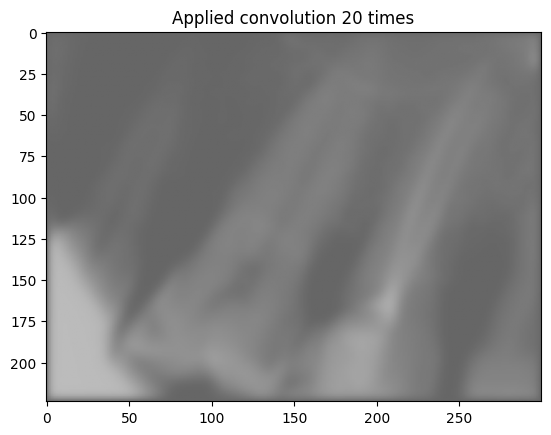

In [ ]:
# convolution w: smoothing
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]]) * 1/16

n_iters = 20

apply_conv(img, kernel, n_iters)

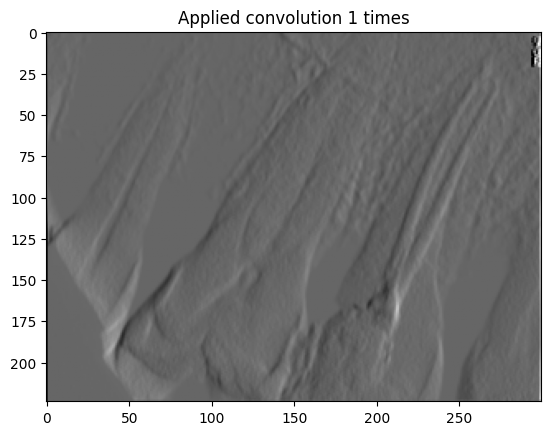

In [ ]:
# convolution: detecting vertical lines
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

n_iters = 1

apply_conv(img, kernel, n_iters)


## Convolutional Neural Network

Οι εν λόγω συνελικτικές λειτουργίες αποτελούν τη βάση ενός λεγόμενου συνελικτικού νευρωνικού δικτύου. Στην ουσία, πρόκειται για ένα νευρωνικό δίκτυο που μπορεί να χρησιμοποιηθεί για διάφορες εργασίες υπολογιστικής όρασης, όπως η ταξινόμηση εικόνων, η ανίχνευση αντικειμένων ή ακόμη και ο προσδιορισμός των ακριβών ορίων ενός αντικειμένου σε μια εικόνα. Τα συνελικτικά νευρωνικά δίκτυα αποτελούνται από μια στοίβα συνελικτικών επιπέδων. Εφαρμόζοντας συνεχώς συνελικτικές λειτουργίες μέσα σε μια «στοίβα», ο υπολογιστής μπορεί να εξετάζει μια ολοένα και μεγαλύτερη τοπική περιοχή γύρω από κάθε εικονοστοιχείο (perceptive field). Οι πυρήνες σε όλες αυτές τις συνελικές λειτουργίες δεν καθορίζονται από ανθρώπους, αλλά προσδιορίζονται κατά τη διάρκεια της εκπαίδευσης αυτού του δικτύου. Στην υπόλοιπη ενότητα αυτού του notebook θα δείξουμε ένα μικρό παράδειγμα του πώς λειτουργεί αυτό και πώς μπορούμε να αξιολογήσουμε πόσο καλό είναι το δίκτυο στη συγκεκριμένη εργασία του.

In [103]:
# Φτιάχνω τις εικόνες που έφτιαξες σε μορφή ώστε να τις διαβάσει το CNN

import cv2
from sklearn.model_selection import train_test_split

images = []
labels = []
orig_images = []

for filename in os.listdir("WorkshopCNNs/Xrays_with"):
  if 'ipynb' in filename: continue
  orig = cv2.imread(f"WorkshopCNNs/Xrays_with/{filename}", cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(orig, (28, 28))
  img = img.astype(np.uint8)

  orig_images.append(orig)
  images.append(img)
  labels.append([1])

for filename in os.listdir("WorkshopCNNs/Xrays_without"):
  if 'ipynb' in filename: continue
  orig = cv2.imread(f"WorkshopCNNs/Xrays_without/{filename}", cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(orig, (28, 28))
  img = img.astype(np.uint8)

  orig_images.append(orig)
  images.append(img)
  labels.append([0])

images = np.array(images)
labels = np.array(labels)
orig_images = np.array(orig_images, dtype=object)

In [104]:
# Split resized images AND original images together
X_train, X_temp, X_train_orig, X_temp_orig, y_train, y_temp = train_test_split( images, orig_images, labels, test_size=0.3 )
X_val, X_test, X_val_orig, X_test_orig, y_val, y_test = train_test_split( X_temp, X_temp_orig, y_temp, test_size=0.5 )

In [105]:
# Opslaan in MedMNIST-formaat
np.savez("teethmnist.npz",
         train_images=X_train, train_labels=y_train, train_orig=X_train_orig,
         val_images=X_val, val_labels=y_val, val_orig=X_val_orig,
         test_images=X_test, test_labels=y_test, test_orig=X_test_orig,)

**De taak:**

We maken gebruik van de zogenaamde pneumonia dataset. Deze bevat gedownsamplede röntgenfoto's van de borstkas, van zowel gezonde patienten als van patienten met een longontsteking. We gaan een neuraal netwerk trainen dat automatisch voor een dergelijk beeld kan bepalen of er sprake is van longontsteking of niet.

In [106]:
from torch.utils.data import Dataset

class TeethMNIST(Dataset):
  def __init__(self, split="train", transform=None):
      data = np.load("teethmnist.npz", allow_pickle=True)

      self.images = data[f"{split}_images"]
      self.labels = data[f"{split}_labels"]
      self.orig_images = data[f"{split}_orig"] # original images

      self.transform = transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img = self.images[idx].astype(np.float32)
      orig = self.orig_images[idx]
      label = int(self.labels[idx])

      # Add channel dimension: (1, H, W)
      img = np.expand_dims(img, axis=0)
      img = torch.tensor(img)

      if self.transform:
          img = self.transform(img)

      return {
          "img": img, # tensor → batched
          "label": label, # scalar → batched
          "orig": orig # numpy → ignored by collate
          }

In [107]:
# A function to visualize the scans
def visualize_sample(sample):
    plt.imshow(sample['img'], 'gray')
    if sample['label'] == 1:
        plt.title('Patient with inflamation')
    else:
        plt.title('Healthy patient')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [108]:
def visualize_sample(sample):
  # Convert tensor → numpy for visualization
  img = sample['img']
  if isinstance(img, torch.Tensor):
      img = img.cpu().numpy()

  # Remove channel dimension (1, H, W) → (H, W)
  img = img.squeeze()

  plt.imshow(img, cmap='gray')

  if sample['label'] == 1:
      plt.title('Patient with inflammation')
  else:
      plt.title('Healthy patient')

  plt.xticks([])
  plt.yticks([])
  plt.show()

In [109]:
import medmnist
%pip install monai

In [110]:
from monai.transforms import NormalizeIntensity

data_transform = NormalizeIntensity(subtrahend=.5, divisor=.5)

train_dataset = TeethMNIST(split="train", transform=data_transform)
# Use only the first 20 images for training
#train_dataset.images = train_dataset.images[:20]
#train_dataset.labels = train_dataset.labels[:20]


val_dataset = TeethMNIST(split="val", transform=data_transform)
test_dataset = TeethMNIST(split="test", transform=data_transform)

### Vraag 1 (doel: experimenteren met code en dataset verkennen):
train_dataset is een verzameling van 4708 scans waarin elke scan een label heeft, deze kan 0 of 1 zijn. Label 0 betekent dat de patient gezond is, en label 1 betekent dat de patient longontsteking heeft , Als je <kbd>visualize(train_dataset[k][‘img’])</kbd> intoetst dan kun je het $k$-de plaatje zien, en als je <kbd>print(train_dataset[k][‘label’])</kbd> intoetst dan zie je de label die bij dat plaatje hoort. Experimenteer met <kbd>visualize_sample(train_dataset[k])</kbd> om de dataset te verkennen.


/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


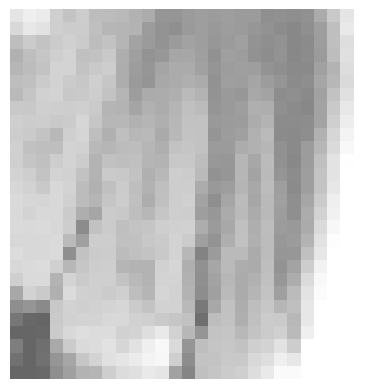

In [111]:
sample = train_dataset[11]
visualize(sample["img"][0])

Hieronder kun je een foto de longen van een willekeurige patient laten zien. Om de voorspellingen van het algoritme later beter te kunnen interpreteren, is het belangrijk om te weten hoe veel foto's er in de data zitten van gezonde longen, en hoe veel er van ongezonde longen inzitten.

Hieronder kun je kijken hoe veel data uit de ene, en uit de andere klasse komen.

**Vraag:** Is de dataset gebelanceerd? Hoe veel procent van de trainingsdata gaat over patienten met een longontsteking?

/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


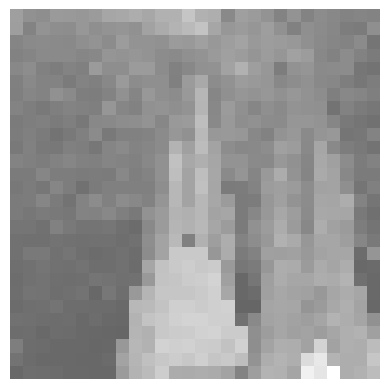

TypeError: 'int' object is not subscriptable

In [112]:
# visualiseer een random sample
index = np.random.choice(np.arange(len(train_dataset)))
sample = train_dataset[index]
visualize(sample["img"][0])

#Vraag: is deze dataset imbalanced?
counts = {0: 0, 1:0}
for sample in train_dataset:
    counts[sample['label'][0]] += 1
print('Aanal label 0:', counts[0], 'Aantal label 1:', counts[1])

Nu gaan we het echte netwerk aanmaken. We splitsen de data in een testset en een validatieset om later te kunnen kijken of het model niet overfit. We maken een model met twee lagen van convoluties van 3x3 kernels. Daarachter komt een neuraal netwerk, en we zorgen dat er één output is (wel of niet longontsteking). Dit model staat geprogrammeerd als Net().


**Vraag:**
Wat is de receptive field van dit netwerk (hoe veel pixels)?

In [113]:
import monai
# validatiedataset aanmaken, om te kijken hoe het model generaliseert tijdens het trainen. De validatieset wordt niet gebruikt om de gewichten van het model op te fitten.
val_dataset = TeethMNIST(split="val", transform=data_transform)

def collate_without_orig(batch): # Remove "orig" from every sample before batching
    batch_no_orig = []
    for sample in batch:
        sample = {k: v for k, v in sample.items() if k != "orig"}
        batch_no_orig.append(sample)
    return monai.data.utils.list_data_collate(batch_no_orig)

# dataloader die de data inlaadt voor het trainen
train_dataloader = monai.data.DataLoader(train_dataset, batch_size=32, shuffle=True,
                                         collate_fn=collate_without_orig)
val_dataloader = monai.data.DataLoader(val_dataset, batch_size = 32, shuffle=False,
                                       collate_fn=collate_without_orig)

In [114]:
# Hier wordt het echte model gedefinieerd. Dit model is een convolutioneel neuraal netwerk (CNN) dat bestaat uit 2 convolutionele lagen en 2 fully connected lagen.
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)             # Een convolutie met 1 input channel (de afbeelding), 32 output channels (32 verschillende kernels), 3x3 pixel kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)            # Een tweede convolutie met 32 input channels (de 32 output channels van de vorige laag), 64 output channels (verschillende kernels), 3x3 pixel kernel
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)                                       # De output laag met 1 output neuron (de voorspelling, tussen 0 (geen longontsteking) en 1( longontsteking) )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

net = Net()


We moeten ook bepalen wat de loss functie is die het netwerk gebruikt als we gaan trainen. We gebruiken de 'binary cross-entropy loss' die we besproken hadden.

In [126]:
model = Net()
model.cuda() # op de GPU zetten, zodat het trainen sneller gaat


optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# loss functie: Binary cross entropy (want classificatie).
loss_function = torch.nn.BCEWithLogitsLoss()

In [127]:
from tqdm import tqdm
# functie om het model te trainen

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device='cuda', val_freq=1):
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(epochs)):
        # model in train modus
        model.train()
        steps = 0
        epoch_loss = 0
        # loop over de batches in training data
        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['label'].float().to(device)
            labels = labels.unsqueeze(1)
            # haal plaatjes door het model
            output = model(images)
            # bereken de loss tussen de targets en de outputs van het model
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            # back propagation, update de weights in het netwerk
            loss.backward()
            optimizer.step()
            steps += 1

        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                images = batch['img'].float().to(device)
                labels = batch['label'].float().to(device)
                labels = labels.unsqueeze(1)
                output = model(images)
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
            val_loss.append(val_epoch_loss/steps)

    # plot the losses together
    plt.plot(train_loss, label='train loss')
    plt.plot(np.arange(0, epochs, val_freq), val_loss, label='val loss')
    plt.legend()
    plt.show()

    return model, train_loss, val_loss

Nu we het neurale netwerk, de loss functie, de data geïntroduceerd is, kunnen we het model echt gaan trainen, en de kernels leren die het model gaat gebruiken om gezonde en ongezonde patiënten te onderscheiden. De code hieronder laat zien hoe de loss functie naar beneden gaat tijdens de training, op zowel te trainingsdata als de validatiedata.


**Vraag:** Als je de plots van de loss functie op de trainingsdata en op de validatiedata ziet, is het model dan overfitted denk je? En nu hebben we het model 100 epochs getraind. Had dit ook korter gekund?

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 100/100 [00:02<00:00, 47.94it/s]


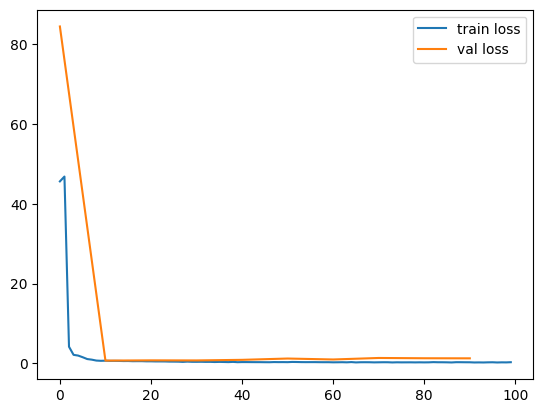

In [128]:
val_freq = 10

# 100 iteraties trainen
n_epochs = 100
model, train_loss, val_loss = train_medmnist(model, train_dataloader,
                                             val_dataloader, optimizer,
                                             epochs=n_epochs, val_freq=val_freq)

We hebben hierboven gezien wat specifieke kernels kunnen herkennen in een beeld. Maar wat heeft ons algoritme voor kernels gevonden om te classificeren tussen gezonde en zieke longen? Hieronder zien we de kernels van de tweede laag van convoluties. Omdat de eerste laag al 16 convoluties heeft gedaan, zijn er 16 verschillende lagen van kernels in de tweede laag. Je kunt ze allemaal bekijken door de variabele <kbd>input_index</kbd> aan te passen.

/tmp/ipython-input-984550202.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


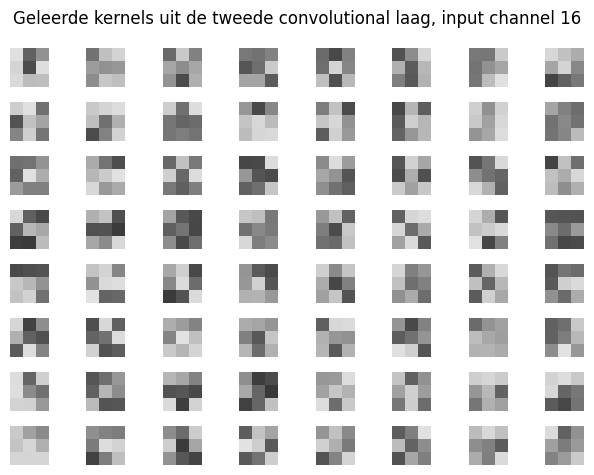

In [118]:
input_index = 16
fig, axs = plt.subplots(8,8, layout='constrained')
for i in range(64):
    kernel = model.conv2.weight[i,input_index,:,:].detach().cpu().numpy()
    cur_ax = np.unravel_index(i, [8,8])
    s = axs[cur_ax].imshow(kernel, clim=[-0.1,0.1],cmap = 'Greys')
    axs[cur_ax].axis('off')
plt.suptitle(f'Geleerde kernels uit de tweede convolutional laag, input channel {input_index}')
plt.tight_layout()
plt.show()

En hier zien we ook de kernels uit de eerste laag van convoluties

torch.Size([32, 1, 3, 3])


/tmp/ipython-input-2024605393.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


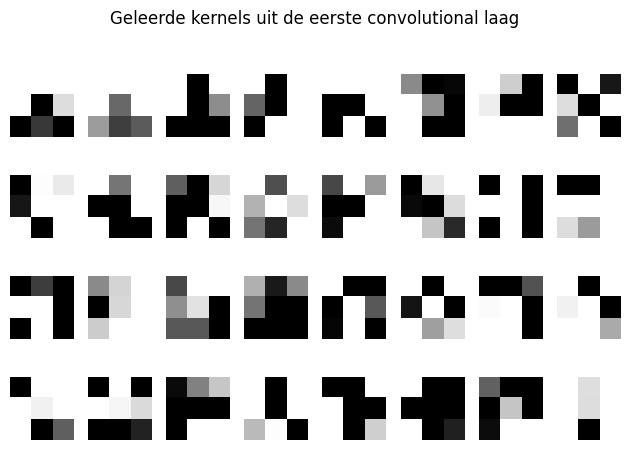

In [119]:
print(np.shape(model.conv1.weight))
fig, axs = plt.subplots(4,8, layout='constrained')
for i in range(32):
    kernel = model.conv1.weight[i,0,:,:].detach().cpu().numpy()
    cur_ax = np.unravel_index(i, [4,8])
    s = axs[cur_ax].imshow(kernel, clim=[-0.1,0.1],cmap = 'Greys')
    axs[cur_ax].axis('off')
plt.suptitle(f'Geleerde kernels uit de eerste convolutional laag')
plt.tight_layout()
plt.show()

## Performance assessment

Nu we het model getraind hebben, gaan we kijken in hoeverre dit model goede voorspellingen kan doen. Eerst bepalen we de recall en precision van het model. De recall vertelt ons hoeveel van de positieven er gemist worden door het model (vals negatieven). De precisie meet hoeveel van de positief geclassificeerde samples daadwerkelijk positieve samples zijn (vals positieven). Welke maat belangrijker is, is afhankelijk van het probleem. Bij het detecteren van een extreem zeldzame vorm van kanker heb je bijvoorbeeld het liefst een hoge recall en accepteer je daarmee een lagere precisie. Het is beter om de daadwerkelijke positieven wél te detecteren en daarmee in een vervolgonderzoek de vals positieven eruit te filteren, dan de positieven compleet te missen.
We gebruiken de test dataset (dus niet de validatiedataset) om deze metrics te bepalen.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Voordat we deze metrics gaan bepalen, bekijken we eerst een paar outputs van het model.


In [120]:
def validation_results_visualize(model, dataset):
    index = np.random.randint(0, len(dataset))
    sample = dataset[index]

    small_image = sample['img']
    label = sample['label']
    orig_img = sample['orig']

    plt.imshow(orig_img, cmap='gray')
    plt.yticks([]); plt.xticks([])

    # convert to tensor
    image_t = torch.tensor(small_image).float().to('cuda') # shape (1,28,28)

    with torch.no_grad():
         output = torch.sigmoid(model(image_t.unsqueeze(0))).item()
         print(index)
         plt.title(f"Πραγματική τιμή: {label}, πιθανότητα απονεύρωσης :{output:.3f}, πρόβλεψη CNN: {int(output >= 0.5)}")
         plt.show()

4


/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-3698399905.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_t = torch.tensor(small_image).float().to('cuda') # shape (1,28,28)


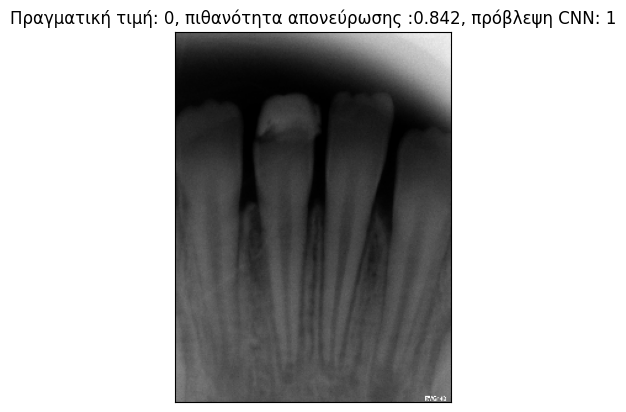

In [121]:
validation_results_visualize(model, test_dataset)

5


/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-3698399905.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_t = torch.tensor(small_image).float().to('cuda') # shape (1,28,28)


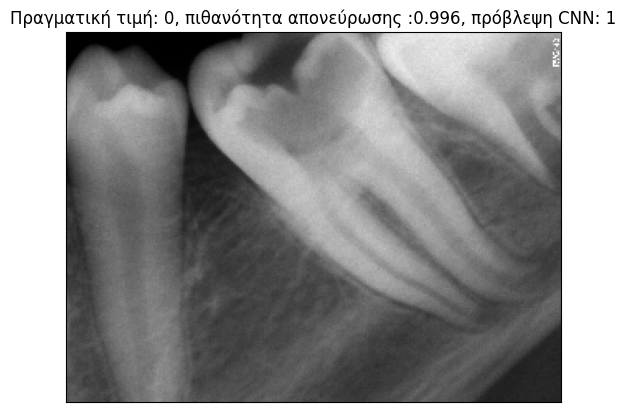

0


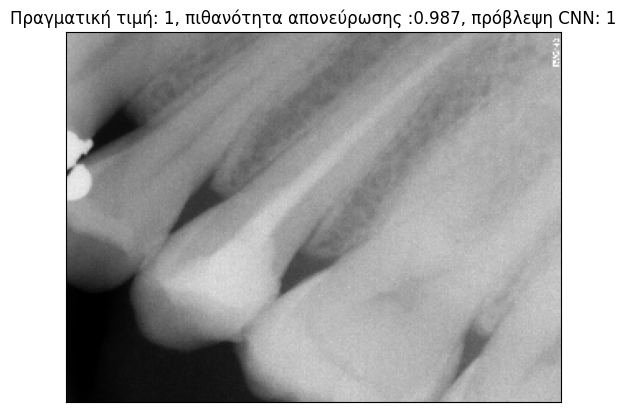

9


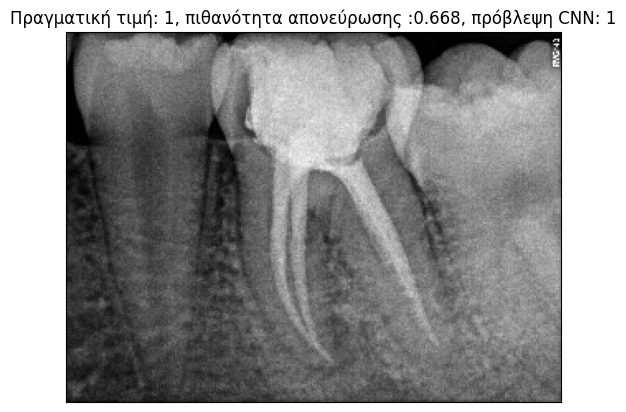

4


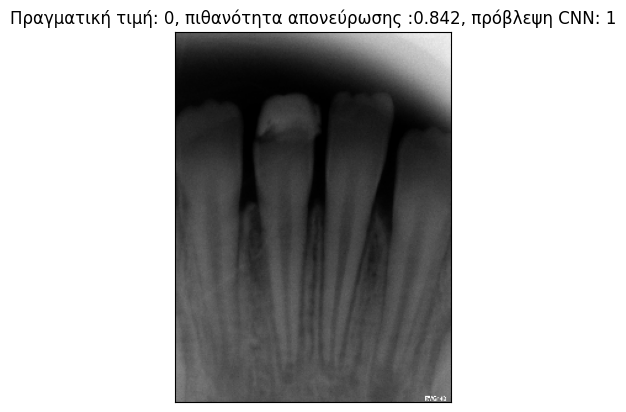

3


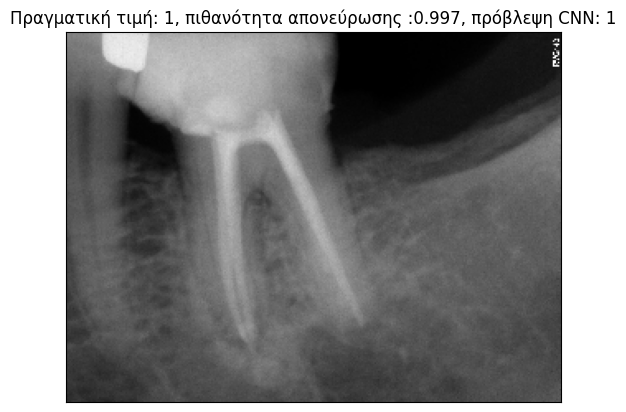

7


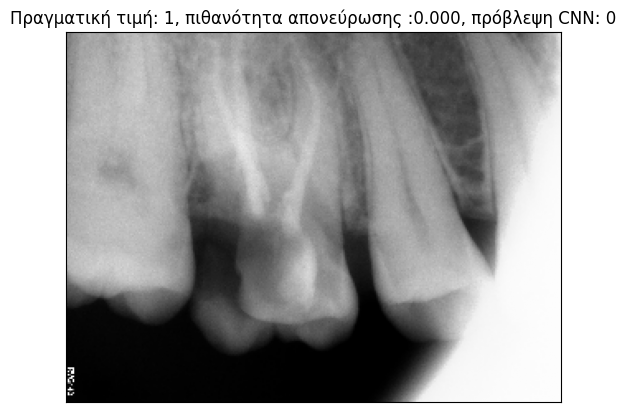

7


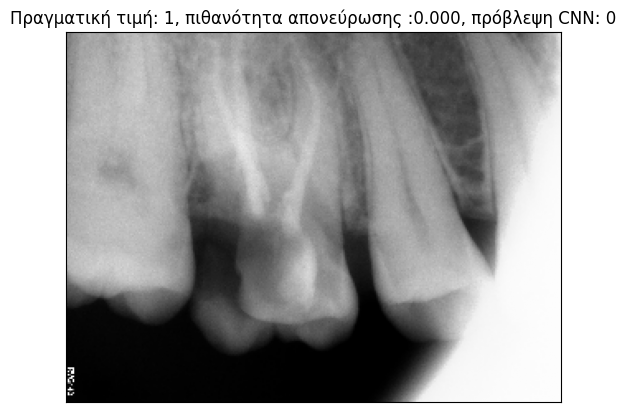

5


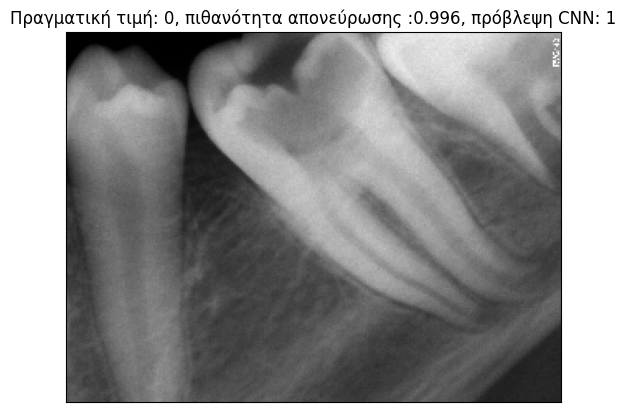

2


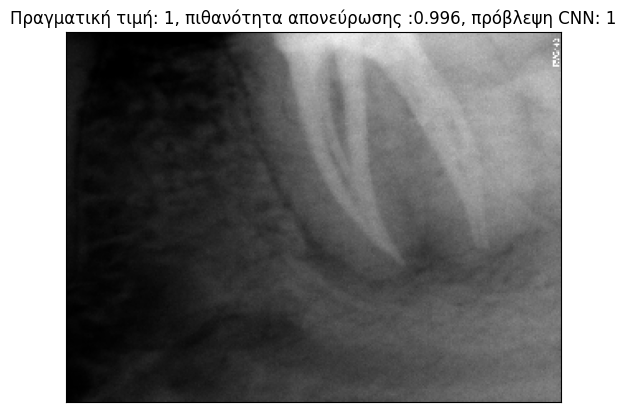

5


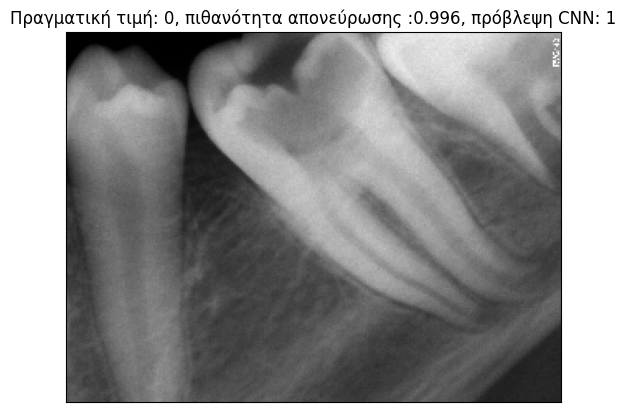

In [122]:
for i in range(10):
    validation_results_visualize(model, test_dataset)

In [123]:
# deze functien berekent de precision en recall van het model
def get_precision_recall(model, dataloader):
    model.eval()
    TP, TN, FP, FN = 0, 0, 0, 0

    with torch.no_grad():
         for batch in dataloader:
             images = batch['img'].float().to('cuda') # (B,1,28,28)
             labels = batch['label'].float().to('cuda') # (B,)
             labels = labels.unsqueeze(1) # (B,1)
             outputs = torch.sigmoid(model(images)) # (B,1)
             preds = (outputs >= 0.5).float() # (B,1)
             TP += ((preds == 1) & (labels == 1)).sum().item()
             TN += ((preds == 0) & (labels == 0)).sum().item()
             FP += ((preds == 1) & (labels == 0)).sum().item()
             FN += ((preds == 0) & (labels == 1)).sum().item()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    return precision, recall

In [124]:
test_dataset = TeethMNIST(split="test",transform=data_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size = 32, shuffle=False,
                                    collate_fn=collate_without_orig)

precision, recall = get_precision_recall(model, test_loader)
print(f'De precision van het getrainde model is {precision:.2f}, de recall van het getrainde model is {recall:.2f}.')

De precision van het getrainde model is 0.67, de recall van het getrainde model is 0.67.


/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


**Vraag:** Wat vind je van de precisie en recall van het model (ook denkend aan hoe veel procent van de patienten in de data longontsteking hebben?)

Hieronder kun je een zogenaamde 'confusion matrix' zien. Hoe veel longontstekingen zijn over het hoofd gezien? En hoe vaak wordt er een patient onterecht gediagnostiseerd met longontsteking? Welk beeld geeft dit van hoe krachtig het model is? Kun je er ook achterkomen of het model ook goed werkt op de validatiedataset? De dataloader voor de validatieset heet <kbd>val_dataloader</kbd>.

/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


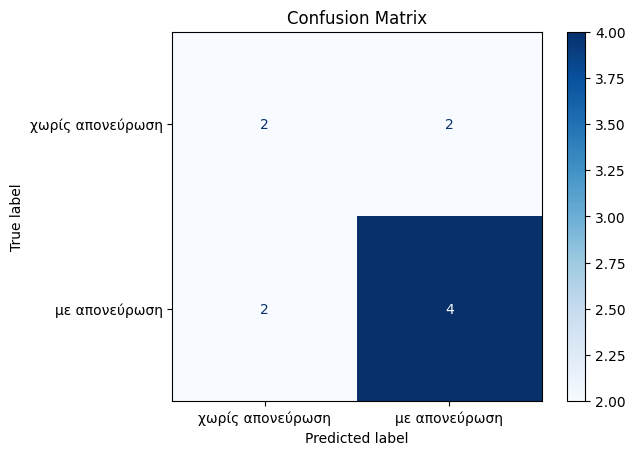

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model,dataloader):
    """
    Plots a confusion matrix using true and predicted labels.

    :param y_true: List or array of true labels.
    :param y_pred: List or array of predicted labels.
    :param labels: List of label names (optional).
    """
    model.eval()
    true_labels = []
    predicted_labels = []


    for data in dataloader:
        images = data['img'].float().to('cuda')
        labels = data['label'].cpu().numpy()
        with torch.no_grad():
            output = torch.sigmoid(model(images)).cpu().numpy().flatten()
        pred_classes = (output >= 0.5).astype(int)
        true_labels.extend(labels)
        predicted_labels.extend(pred_classes)

    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['χωρίς απονεύρωση', 'με απονεύρωση'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        self.model.zero_grad()
        output.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()

        cam = cam.cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()

        return cam

def visualize_gradcam(model, dataset, index, device='cuda'):
    sample = dataset[index]

    small_img = sample['img'].unsqueeze(0).float().to(device)
    orig_img = sample['orig']
    label = sample['label']

    gradcam = GradCAM(model, model.conv2)
    cam = gradcam.generate(small_img)

    cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = 0.4 * heatmap + 0.6 * np.stack([orig_img]*3, axis=-1)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Original (label={label})")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.show()

In [150]:
test_dataset[1]

/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


{'img': metatensor([[[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,   1.,   1.,
             1.,   1.,   3.,   3.,   1.,   1.,   3.,   3.,   3.,   5.,   5.,
             5.,   5.,   5.,   5.,   5.,   5.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,   1.,   1.,   1.,   1.,   3.,   5.,
            23.,  37.,  33.,   7.,   3.,   3.,  11.,  39.,  53.,  31.,   9.,
             5.,   7.,   7.,   7.,   5.,   5.],
          [ -1.,  -1.,  -1.,  -1.,  -1.,   1.,   3.,   3.,   3.,  59., 111.,
           161., 179., 167., 141.,  61., 105., 135., 205., 207., 169., 143.,
            95.,   7.,   9.,   7.,   9.,   9.],
          [ -1.,  -1.,   1.,   3., 101., 163., 177., 137.,   9., 181., 205.,
           257., 269., 265., 263., 201., 167., 209., 277., 279., 243., 235.,
           229.,  49.,  99.,  77.,  45.,  17.],
          [  1.,   1.,  11., 149., 221., 245., 247., 211., 145., 343., 375.,
           351., 349., 345., 335., 301., 223., 281., 331., 333., 341., 329.,
           317., 179., 205.

/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


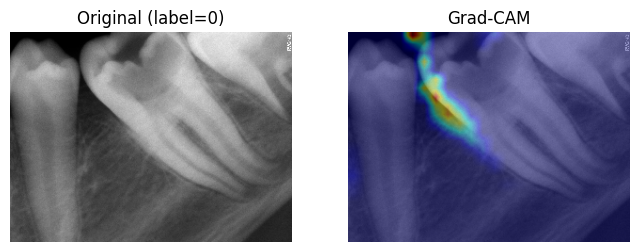

In [174]:
visualize_gradcam(model, test_dataset, 5)

5


/tmp/ipython-input-456734757.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
/tmp/ipython-input-3698399905.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_t = torch.tensor(small_image).float().to('cuda') # shape (1,28,28)


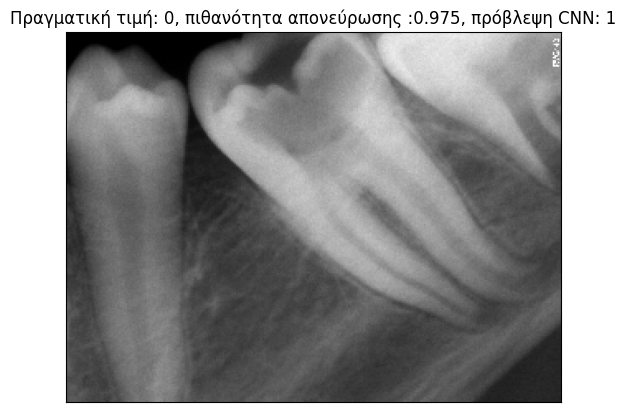

In [173]:
validation_results_visualize(model, test_dataset)